In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Ref: https://chatgpt.com/g/g-p-68eeaa4162b48191a6ab8b31241aee84-evolution-of-trust-simulation/c/68ec0088-5e20-8328-9eb2-6609cd7e5720

In [2]:
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# T>R>P>S and 2R>T+S
# Typical example: T=5,R=3,P=1,S=0 (but keep it symbolic).

In [4]:
# -----------------------------
# PAYOFF MATRIX
# -----------------------------
# Payoffs for (player, opponent)
# R = Reward (mutual cooperation)
# T = Temptation (you defect, they cooperate)
# P = Punishment (mutual defection)
# S = Sucker (you cooperate, they defect)

R, T, P, S = 3, 5, 1, 0
PAYOFFS = {
    ('C', 'C'): (R, R),
    ('C', 'D'): (S, T),
    ('D', 'C'): (T, S),
    ('D', 'D'): (P, P)
}

In [5]:
# -----------------------------
# STRATEGY DEFINITIONS
# -----------------------------
class Strategy:
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.history = []

    def move(self, opponent_history):
        raise NotImplementedError


class Cooperator(Strategy):
    def __init__(self): super().__init__("Cooperator")
    def move(self, opponent_history): return 'C'


class Cheater(Strategy):
    def __init__(self): super().__init__("Cheater")
    def move(self, opponent_history): return 'D'


class Copycat(Strategy):
    def __init__(self): super().__init__("Copycat")
    def move(self, opponent_history):
        return 'C' if not opponent_history else opponent_history[-1]


class Grudger(Strategy):
    def __init__(self):
        super().__init__("Grudger")
        self.grudge = False
    def reset(self):
        super().reset(); self.grudge = False
    def move(self, opponent_history):
        if 'D' in opponent_history:
            self.grudge = True
        return 'D' if self.grudge else 'C'


class Detective(Strategy):
    def __init__(self):
        super().__init__("Detective")
        self.probe_moves = ['D', 'C', 'C', 'D']
    def reset(self):
        super().reset(); self.phase = "probe"
    def move(self, opponent_history):
        if len(self.history) < 4:
            return self.probe_moves[len(self.history)]
        if 'D' not in opponent_history:
            return 'D'  # exploit
        else:
            return opponent_history[-1]  # play Copycat


class Copykitten(Strategy):
    def __init__(self): super().__init__("Copykitten")
    def move(self, opponent_history):
        if len(opponent_history) < 2:
            return 'C'
        if opponent_history[-1] == 'D' and opponent_history[-2] == 'D':
            return 'D'
        return 'C'


In [6]:
# -----------------------------
# GAME MECHANICS
# -----------------------------

def play_round(p1, p2, noise=0.0):
    """Play one noisy round."""
    m1 = p1.move(p2.history)
    m2 = p2.move(p1.history)

    if random.random() < noise: m1 = 'D' if m1 == 'C' else 'C'
    if random.random() < noise: m2 = 'D' if m2 == 'C' else 'C'

    p1.history.append(m1)
    p2.history.append(m2)
    return PAYOFFS[(m1, m2)]


def play_match(p1, p2, rounds=50, noise=0.0):
    """Run multiple rounds and return average payoffs."""
    p1.reset(); p2.reset()
    total1 = total2 = 0
    for _ in range(rounds):
        pay1, pay2 = play_round(p1, p2, noise)
        total1 += pay1
        total2 += pay2
    return total1 / rounds, total2 / rounds


def tournament(strategies, rounds=50, noise=0.0):
    """Compute the full payoff matrix between all strategies."""
    n = len(strategies)
    payoff_matrix = np.zeros((n, n))
    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):
            avg1, _ = play_match(s1, s2, rounds, noise)
            payoff_matrix[i, j] = avg1
    return payoff_matrix

In [7]:
# -----------------------------
# EVOLUTION WITH MUTATION
# -----------------------------

def evolve(strategies, generations=100, rounds=100, noise=0.05,
           mutation_rate=0.01, initial_freq=None):
    """
    Simulate replicator-mutator dynamics.
    Each generation: 
    - strategies play
    - reproduce proportionally to payoff
    - small chance of mutation between strategies
    """
    names = [s.name for s in strategies]
    n = len(strategies)

    if initial_freq is None:
        freqs = np.ones(n) / n
    else:
        freqs = np.array(initial_freq) / sum(initial_freq)

    history = [freqs.copy()]

    for gen in range(generations):
        payoff_matrix = tournament(strategies, rounds, noise)
        avg_payoffs = payoff_matrix.dot(freqs)
        mean_fitness = np.dot(freqs, avg_payoffs)

        # Replicator step
        new_freqs = freqs * (avg_payoffs / mean_fitness)

        # Mutation step (uniform small probability of switching)
        mutation_matrix = np.ones((n, n)) * (mutation_rate / (n - 1))
        np.fill_diagonal(mutation_matrix, 1 - mutation_rate)
        new_freqs = mutation_matrix.T.dot(new_freqs)

        # Normalize
        new_freqs /= new_freqs.sum()
        freqs = new_freqs
        history.append(freqs.copy())

    return np.array(history), names

Typical Behavior
- If noise = 0, Copycat often dominates (perfect reciprocity).
- With small noise (≈ 0.05), Copykitten often wins — it’s forgiving.
- If noise is high or discounting matters less, Grudger and Cheater may reappear.

# Run Simulation

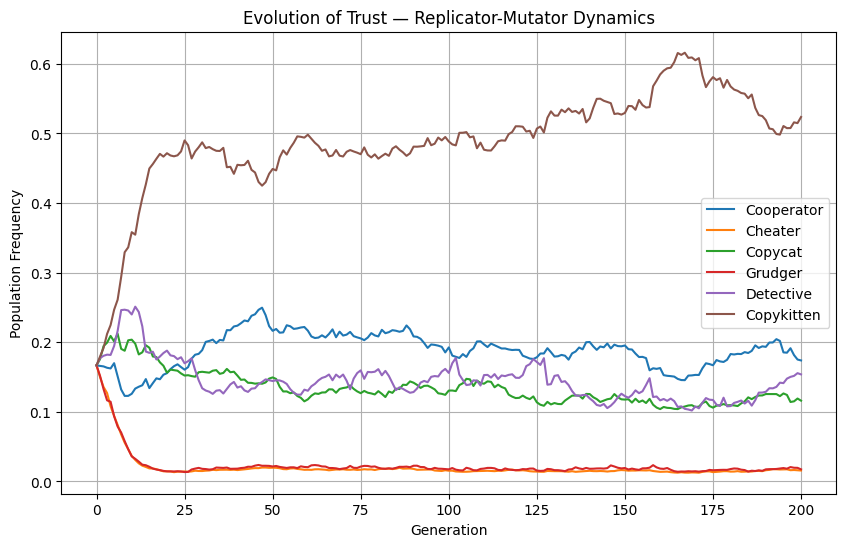

In [8]:
# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)

    strategies = [
        Cooperator(),
        Cheater(),
        Copycat(),
        Grudger(),
        Detective(),
        Copykitten()
    ]

    history, names = evolve(
        strategies,
        generations=200,
        rounds=100,
        noise=0.05,
        mutation_rate=0.02
    )

    # Plot evolution
    plt.figure(figsize=(10,6))
    for i, name in enumerate(names):
        plt.plot(history[:, i], label=name)
    plt.title("Evolution of Trust — Replicator-Mutator Dynamics")
    plt.xlabel("Generation")
    plt.ylabel("Population Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import interact, FloatSlider, IntSlider
from IPython.display import display, clear_output

# -----------------------------
# PAYOFF MATRIX
# -----------------------------
R, T, P, S = 3, 5, 1, 0
PAYOFFS = {
    ('C', 'C'): (R, R),
    ('C', 'D'): (S, T),
    ('D', 'C'): (T, S),
    ('D', 'D'): (P, P)
}

# -----------------------------
# STRATEGY CLASSES
# -----------------------------
class Strategy:
    def __init__(self, name): self.name = name; self.reset()
    def reset(self): self.history = []
    def move(self, opponent_history): raise NotImplementedError

class Cooperator(Strategy):
    def __init__(self): super().__init__("Cooperator")
    def move(self, opponent_history): return 'C'

class Cheater(Strategy):
    def __init__(self): super().__init__("Cheater")
    def move(self, opponent_history): return 'D'

class Copycat(Strategy):
    def __init__(self): super().__init__("Copycat")
    def move(self, opponent_history):
        return 'C' if not opponent_history else opponent_history[-1]

class Grudger(Strategy):
    def __init__(self): super().__init__("Grudger"); self.grudge = False
    def reset(self): super().reset(); self.grudge = False
    def move(self, opponent_history):
        if 'D' in opponent_history: self.grudge = True
        return 'D' if self.grudge else 'C'

class Detective(Strategy):
    def __init__(self): super().__init__("Detective"); self.probe_moves = ['D','C','C','D']
    def reset(self): super().reset()
    def move(self, opponent_history):
        if len(self.history) < 4: return self.probe_moves[len(self.history)]
        if 'D' not in opponent_history: return 'D'
        return opponent_history[-1]

class Copykitten(Strategy):
    def __init__(self): super().__init__("Copykitten")
    def move(self, opponent_history):
        if len(opponent_history) < 2: return 'C'
        if opponent_history[-1] == 'D' and opponent_history[-2] == 'D': return 'D'
        return 'C'

# -----------------------------
# GAME MECHANICS
# -----------------------------
def play_round(p1, p2, noise=0.0):
    m1, m2 = p1.move(p2.history), p2.move(p1.history)
    if random.random() < noise: m1 = 'D' if m1 == 'C' else 'C'
    if random.random() < noise: m2 = 'D' if m2 == 'C' else 'C'
    p1.history.append(m1); p2.history.append(m2)
    return PAYOFFS[(m1, m2)]

def play_match(p1, p2, rounds=50, noise=0.0):
    p1.reset(); p2.reset()
    total1 = total2 = 0
    for _ in range(rounds):
        pay1, pay2 = play_round(p1, p2, noise)
        total1 += pay1; total2 += pay2
    return total1 / rounds, total2 / rounds

def tournament(strategies, rounds=50, noise=0.0):
    n = len(strategies)
    payoff_matrix = np.zeros((n, n))
    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):
            avg1, _ = play_match(s1, s2, rounds, noise)
            payoff_matrix[i, j] = avg1
    return payoff_matrix

# -----------------------------
# EVOLUTION WITH MUTATION
# -----------------------------
def evolve_step(freqs, strategies, rounds=80, noise=0.05, mutation_rate=0.02):
    n = len(strategies)
    payoff_matrix = tournament(strategies, rounds, noise)
    avg_payoffs = payoff_matrix.dot(freqs)
    mean_fitness = np.dot(freqs, avg_payoffs)
    new_freqs = freqs * (avg_payoffs / mean_fitness)
    mutation_matrix = np.ones((n, n)) * (mutation_rate / (n - 1))
    np.fill_diagonal(mutation_matrix, 1 - mutation_rate)
    new_freqs = mutation_matrix.T.dot(new_freqs)
    return new_freqs / new_freqs.sum()

# -----------------------------
# INTERACTIVE EVOLUTION SIMULATION
# -----------------------------
def run_simulation(noise=0.05, mutation_rate=0.02, generations=200, rounds=80):
    random.seed(42)
    np.random.seed(42)

    strategies = [
        Cooperator(),
        Cheater(),
        Copycat(),
        Grudger(),
        Detective(),
        Copykitten()
    ]
    names = [s.name for s in strategies]
    freqs = np.ones(len(strategies)) / len(strategies)
    history = [freqs.copy()]

    for g in range(generations):
        freqs = evolve_step(freqs, strategies, rounds, noise, mutation_rate)
        history.append(freqs.copy())

    history = np.array(history)

    plt.figure(figsize=(10,6))
    for i, name in enumerate(names):
        plt.plot(history[:, i], label=name)
    plt.title(f"Evolution of Trust — noise={noise:.2f}, mutation={mutation_rate:.2f}")
    plt.xlabel("Generation")
    plt.ylabel("Population Frequency")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------
# INTERACTIVE WIDGETS
# -----------------------------
interact(
    run_simulation,
    noise=FloatSlider(value=0.05, min=0, max=0.2, step=0.01, description='Noise'),
    mutation_rate=FloatSlider(value=0.02, min=0, max=0.1, step=0.005, description='Mutation'),
    generations=IntSlider(value=200, min=50, max=500, step=10, description='Generations'),
    rounds=IntSlider(value=80, min=20, max=200, step=10, description='Rounds')
);


interactive(children=(FloatSlider(value=0.05, description='Noise', max=0.2, step=0.01), FloatSlider(value=0.02…